# Wrangling: Energy Performance of Buildings Data England

In this notebook we present the steps made to clean and organize the EPC data.

> The organization must follow the standards present in the synthetic population.

To know more about the EPC data, please see the [01-EPC_data_Overview.ipynb](01-EPC_data_Overview.ipynb) notebook.

## EPC data

Data on the energy performance of buildings in England and Wales can be obtained from the Energy Performance Certificate (EPC) provided [here](https://epc.opendatacommunities.org/) (you will need to register to access the data).

For this work, we downloaded all available files (button `All results (.zip)`).

* EPCs issued from January 2008 up to and including 30 June 2021.
* 21,440,172 Domestic EPCs
* Download: 18 October 2021

## Wrangling proccess description

To wrangling the EPC data, the following steps were applied for each column:

1. Get the desired values and codes from the MSM data;
    * if the variable is not present in the MSM data, define a desired code/value table.
1. Get all the values from the EPC data;
1. Assign a code to each EPC value following the MSM description (or the desired code/value table);
    * If the row has no value (or has a value with no match), the value -1 will be used;
1. Create a lookup dictionary;
1. Go through the entire table updating values based on the lookup dictionary;
1. Save the updated table;

## Initialisation

### Import necessary modules

In [1]:
import pandas as pd
import zipfile
import os
from tqdm import tqdm  # add progress bar
import numpy as np

### Defining necessary parameters

#### Empty value

* `empty`: value to be used in fields with empty, unknow, or uncategorised values

In [2]:
empty = -1

#### EPC zip file

* `epc_zip_file`: zip raw file containing all available epc data

In [3]:
epc_zip_file = zipfile.ZipFile(os.path.join('data', 'all-domestic-certificates.zip'))

#### England certificate files

* `epc_files` is a list containing the paths of all certificates available for England inside `epc_zip_file`

In [4]:
# get the path of all certificate files
epc_files = [text_file.filename for text_file in epc_zip_file.infolist() if text_file.filename.endswith('certificates.csv')]

# return just the certificates for England local authorities
epc_files = [folder for folder in epc_files if folder.split('-')[1][0] is 'E']
epc_files

['domestic-E07000044-South-Hams/certificates.csv',
 'domestic-E07000078-Cheltenham/certificates.csv',
 'domestic-E07000145-Great-Yarmouth/certificates.csv',
 'domestic-E07000169-Selby/certificates.csv',
 'domestic-E07000026-Allerdale/certificates.csv',
 'domestic-E07000228-Mid-Sussex/certificates.csv',
 'domestic-E08000031-Wolverhampton/certificates.csv',
 'domestic-E09000003-Barnet/certificates.csv',
 'domestic-E07000073-Harlow/certificates.csv',
 'domestic-E07000096-Dacorum/certificates.csv',
 'domestic-E09000024-Merton/certificates.csv',
 'domestic-E07000176-Rushcliffe/certificates.csv',
 'domestic-E07000034-Chesterfield/certificates.csv',
 'domestic-E06000027-Torbay/certificates.csv',
 'domestic-E07000084-Basingstoke-and-Deane/certificates.csv',
 'domestic-E06000059-Dorset/certificates.csv',
 'domestic-E06000019-Herefordshire-County-of/certificates.csv',
 'domestic-E07000008-Cambridge/certificates.csv',
 'domestic-E07000080-Forest-of-Dean/certificates.csv',
 'domestic-E07000103-Wat

#### Desired columns

* `epc_desired_headers`: list with all parameters necessary for this project;

Each file has 90 columns and the complete **glossary** is available [here](https://epc.opendatacommunities.org/docs/guidance#glossary). For instance, the required headers are:

* `POSTCODE`: The postcode of the property

* `LOCAL_AUTHORITY`: Office for National Statistics (ONS) code. Local authority area in which the building is located.

* `PROPERTY_TYPE`: Describes the type of building that is being inspected. Based on planning use class.

* `BUILT_FORM`: The building type of the Property e.g. Detached, Semi-Detached, Terrace etc. Together with the Property Type, the Build Form produces a structured description of the property

* `CONSTRUCTION_AGE_BAND`: Age band when building part constructed. England & Wales only. One of: before 1900; 1900-1929; 1930-1949; 1950-1966; 1967-1975; 1976-1982; 1983-1990; 1991-1995; 1996-2002; 2003-2006; 2007-2011; 2012 onwards.

* `TENURE`: Describes the tenure type of the property. One of: Owner-occupied; Rented (social); Rented (private).

* `TOTAL_FLOOR_AREA`: Total Useful Floor Area (m²)

* `NUMBER_HABITABLE_ROOMS`: Habitable rooms include any living room, sitting room, dining room, bedroom, study and similar; and also a non-separated conservatory. A kitchen/diner having a discrete seating area (with space for a table and four chairs) also counts as a habitable room. A non-separated conservatory adds to the habitable room count if it has an internal quality door between it and the dwelling. Excluded from the room count are any room used solely as a kitchen, utility room, bathroom, cloakroom, en-suite accommodation and similar and any hallway, stairs or landing; and also any room not having a window.


> Each header must be organized according to be consistent with the MSM data and with the Propensity Score Matching method.

In [5]:
epc_desired_headers = [
        'POSTCODE',
        'LOCAL_AUTHORITY',
        'PROPERTY_TYPE',
        'BUILT_FORM',        
        'CONSTRUCTION_AGE_BAND',
        'TENURE',    
        'TOTAL_FLOOR_AREA',  # m²
        'NUMBER_HABITABLE_ROOMS',
        #'ENERGY_CONSUMPTION_CURRENT',
        #'CURRENT_ENERGY_RATING'
        ]

### Defining necessary functions

In [6]:
def set_categorical_code(df, df_col, lookup, empty=False, rename=False):
    '''
     Transform a categorical column using a lookup 
     for a categorical value in df.

     :param df: The input dataframe
     :param df_col: The column in df that represents the categorical values
     :param lookup: A dict of 'categorical_value -> categorical_code'
     :param empty: The value to be used in empty items (if false, empty lines are dropped)
     :param rename: The new column name after transformation (if false, keep the current name).
    '''
    
    def augment(x, lookup):  # This looks redundant, but ensures that the function works even for missing values.
        try:
            return lookup[x]
        except:
            return

    # setting new values according the rename_dict
    df[df_col] = df[df_col].apply(func=lambda x: augment(x, lookup))
    
    # fill empty columns
    if empty:
        df[df_col].fillna(empty, inplace=True)
    else:
        df.dropna(subset = [df_col], inplace=True)
    
    # rename
    if rename:
        df.rename({df_col: rename}, axis=1, inplace=True)
    
    return df

In [7]:
def set_numerical_code(df, df_col, lookup, empty=False, rename=False):
    '''
     Transform a numerical column using a lookup 
     for a numerical value in df, following 
     the rule:
     - if (j < value <= k), then, (value = i)
     
     :param df: The input dataframe
     :param df_col: The column in df that represents the categorical values
     :param empty: The value to be used in empty items (if false, empty lines are dropped)
     :param rename: The new column name after transformation.
     :param lookup: A dict of 'numerical_value -> numerical_code'
      - [[i1, j1, k1], [i2, j2, k2], ..., [iN, jN, kN]], where:
       * iN: desired code for band N
       * jN: minimum value of the band N (not included)
       * kN: maximum value of the band N (included)
       * N: number of bands
    '''
    for band in lookup:
        df.loc[(df[df_col] > band[1]) & (df[df_col] <= band[2]), df_col] = band[0]
        
    # fill empty columns
    if empty:
        df[df_col].fillna(empty, inplace=True)
    else:
        df.dropna(subset = [df_col], inplace=True)
    
    # rename
    if rename:
        df.rename({df_col: rename}, axis=1, inplace=True)
        
    return df

## Defining lookup for each column

### Location

#### Location in MSM data

According the documentation, in the MSM data, each household is allocated in a Local Authority and a **Middle Layer Super Output Area** (MSOA).

#### Location in EPC data

The accommodation locations on EPC data are organized by Local Authority and by postcode.

Therefore, the first step is to use postcode information to assign the MSOA code to each accommodation present in EPC data.

#### Defining the location lookup

Next, we will determine the tenure lookup (`tenure_lookup`) by combining the values that appear in the EPC data with the MSM categories.

> check if this values are the same for your EPC data version - if necessary, update the lists bellow.


Data for linking an MSOA code to a postcode is provided by the [Open Geography portal from the Office for National Statistics](https://geoportal.statistics.gov.uk/)

Several versions are available. Here, data from [November 2020](https://geoportal.statistics.gov.uk/datasets/postcode-to-output-area-to-lower-layer-super-output-area-to-middle-layer-super-output-area-to-local-authority-district-november-2020-lookup-in-the-uk/about) (the same data reported in the synthetic population) will be used.

**Path:** please put the file in: `msoa/PCD_OA_LSOA_MSOA_LAD_NOV20_UK_LU.csv`

In [8]:
msoa_zip_file = "data/PCD_OA_LSOA_MSOA_LAD_NOV20_UK_LU.zip"
msoa_lookup = pd.read_csv(msoa_zip_file, usecols=["pcds", "msoa11cd"])
msoa_lookup = msoa_lookup.set_index('pcds', drop=True).loc[:,'msoa11cd'].to_dict()

### Tenure

#### Tenure in MSM data

According the documentation, in the MSM data, the tenure column is organized according to:

```json
   "LC4402_C_TENHUK11": {
      "0": "All categories: Tenure",
      "1": "Owned or shared ownership: Total",
      "2": "Owned: Owned outright",
      "3": "Owned: Owned with a mortgage or loan or shared ownership",
      "4": "Rented or living rent free: Total",
      "5": "Rented: Social rented",
      "6": "Rented: Private rented or living rent free"
    }
```

#### Tenure in EPC data

Lets check all Tenure values that appears on the EPC data:

In [9]:
all_tenures = []
for file in epc_files:
    epc_df = pd.read_csv(epc_zip_file.open(file), usecols=['TENURE'], low_memory=False)
    values = list(epc_df.TENURE.unique())
    all_tenures.extend(values)
    
all_tenures = list(set(all_tenures))
print(all_tenures)

del epc_df, values, all_tenures

[nan, 'Not defined - use in the case of a new dwelling for which the intended tenure in not known. It is no', 'owner-occupied', 'Owner-occupied', 'Rented (private)', 'rental (social)', 'NO DATA!', 'rental (private)', 'Rented (social)', 'unknown']


#### Defining the tenure lookup

Next, we will determine the tenure lookup (`tenure_lookup`) by combining the values that appear in the EPC data with the MSM categories.

> check if this values are the same for your EPC data version - if necessary, update the lists bellow.

In [10]:
all_tenures = [
        # 1?
        'Owner-occupied',
        'owner-occupied',
        # 5
        'rental (social)',
        'Rented (social)',
        # 6
        'rental (private)',
        'Rented (private)',
        # empty
        'Not defined - use in the case of a new dwelling for which the intended tenure in not known. It is no',
        'unknown',
        'NO DATA!'
        ]

tenures_codes = [
        1, 1,
        5, 5,
        6, 6,
        empty, empty, empty
        ]

tenure_lookup = pd.DataFrame({'all_tenures':all_tenures, 'tenures_codes':tenures_codes})
tenure_lookup = tenure_lookup.set_index('all_tenures').to_dict()['tenures_codes']

del all_tenures, tenures_codes

### Accommodation type

#### Accommodation type in MSM data
According the documentation, in the MSM data, the accommodation type column is organized according to:

```json
    "LC4402_C_TYPACCOM": {
      "0": "All categories: Accommodation type",
      "1": "Whole house or bungalow: Total",
      "2": "Whole house or bungalow: Detached",
      "3": "Whole house or bungalow: Semi-detached",
      "4": "Whole house or bungalow: Terraced (including end-terrace)",
      "5": "Flat, maisonette or apartment, or mobile/temporary accommodation"
    }
```

#### Accommodation type in EPC data

Note that, in the MSM data, the property type and the built form are aggregated. The the same approach will be taken with EPC data. Lets check all Accommodation type (`PROPERTY_TYPE` + `BUILT_FORM`) values that appears on the EPC data.

In [11]:
all_accommodations = []
for file in epc_files:
    epc_df = pd.read_csv(epc_zip_file.open(file), usecols=['PROPERTY_TYPE', 'BUILT_FORM'], low_memory=False)
    epc_df['LC4402_C_TYPACCOM'] = epc_df['PROPERTY_TYPE'] + ': ' + epc_df['BUILT_FORM']
    values = list(epc_df.LC4402_C_TYPACCOM.unique())
    all_accommodations.extend(values)

all_accommodations = list(set(all_accommodations))
print(all_accommodations)

del epc_df, values, all_accommodations

[nan, 'House: Detached', 'Maisonette: Detached', 'House: End-Terrace', 'Maisonette: Mid-Terrace', 'Maisonette: Enclosed End-Terrace', 'House: Enclosed Mid-Terrace', 'House: Mid-Terrace', 'Bungalow: NO DATA!', 'Flat: Semi-Detached', 'Bungalow: Detached', 'Maisonette: End-Terrace', 'Bungalow: Enclosed End-Terrace', 'Bungalow: Semi-Detached', 'Bungalow: End-Terrace', 'Flat: End-Terrace', 'Flat: NO DATA!', 'Maisonette: NO DATA!', 'Maisonette: Semi-Detached', 'Flat: Detached', 'Bungalow: Mid-Terrace', 'Flat: Enclosed Mid-Terrace', 'Park home: Semi-Detached', 'House: NO DATA!', 'Bungalow: Enclosed Mid-Terrace', 'Flat: Mid-Terrace', 'Maisonette: Enclosed Mid-Terrace', 'House: Enclosed End-Terrace', 'House: Semi-Detached', 'Park home: Detached', 'Flat: Enclosed End-Terrace']


#### Defining the  accommodation type lookup

Next, we will determine the  accommodation type dictionary (`accommodation_rename_dict`) by combining the values that appear in the EPC data with the MSM categories.

Based on the values printed above, 30 different categorical values are observed in the EPC data.

> check if this values are the same for your EPC data version - if necessary, update the lists bellow.

In [12]:
all_accommodations = [
        # 2
        'House: Detached',
        'Bungalow: Detached',
        # 3
        'House: Semi-Detached',
        'Bungalow: Semi-Detached',
        # 4
        'House: Mid-Terrace',
        'House: End-Terrace',
        'House: Enclosed Mid-Terrace',
        'House: Enclosed End-Terrace',
        'Bungalow: Mid-Terrace',
        'Bungalow: End-Terrace',
        'Bungalow: Enclosed Mid-Terrace',
        'Bungalow: Enclosed End-Terrace',
        # 5
        'Flat: NO DATA!',
        'Flat: Detached',
        'Flat: Semi-Detached',
        'Flat: Mid-Terrace',
        'Flat: End-Terrace',
        'Flat: Enclosed Mid-Terrace',
        'Flat: Enclosed End-Terrace',
        'Maisonette: NO DATA!',
        'Maisonette: Detached',
        'Maisonette: Semi-Detached',
        'Maisonette: Mid-Terrace',
        'Maisonette: End-Terrace',
        'Maisonette: Enclosed Mid-Terrace',
        'Maisonette: Enclosed End-Terrace',
        'Park home: Detached',
        'Park home: Semi-Detached',
        # -9?
        'House: NO DATA!',
        'Bungalow: NO DATA!',
        ]

accommodations_codes = [
        2,2,
        3,3,
        4,4,4,4,4,4,4,4,
        5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,
        empty, empty,
        ]

accommodation_df = pd.DataFrame({'all_accommodations':all_accommodations, 'accommodations_codes':accommodations_codes})
accommodation_lookup = accommodation_df.set_index('all_accommodations').to_dict()['accommodations_codes']

del all_accommodations, accommodations_codes, accommodation_df

### Accommodation age

#### Accommodation age in MSM

According the documentation, in the MSM data, the Construction age band column is organized according to:

```json
    "ACCOM_AGE": {
      "0": "All categories: Construction age band",
      "1": "Pre 1930",
      "2": "1930-1949",
      "3": "1950-1966",
      "4": "1967-1975",
      "5": "1976-1982",
      "6": "1983-1990",
      "7": "1991-1995",
      "8": "1996-2002",
      "9": "2003-2006",
      "10": "Post-2007
    }
```

#### Accommodation age in EPC data

In [13]:
all_ages = []
for file in epc_files:
    epc_df = pd.read_csv(epc_zip_file.open(file), usecols=['CONSTRUCTION_AGE_BAND'], low_memory=False)
    values = list(epc_df.CONSTRUCTION_AGE_BAND.unique())
    all_ages.extend(values)
    
all_ages = list(set(all_ages))
print(all_ages)

del epc_df, values, all_ages

[nan, 'INVALID!', 'England and Wales: 1991-1995', '2007', '2015', '1900', '2011', '1902', '1800', '2009', 'England and Wales: 1996-2002', '2004', '2020', '1960', '2021', '2006', '1950', '2012', 'England and Wales: 1967-1975', '1929', '2008', '1920', '2013', '2024', '1992', 'England and Wales: 1900-1929', '1980', '1820', '1969', '1850', '2022', '1930', '2019', 'England and Wales: 1976-1982', 'England and Wales: 1930-1949', 'Not applicable', '2018', 'England and Wales: 1950-1966', 'England and Wales: 2003-2006', 'England and Wales: 2007 onwards', 'England and Wales: before 1900', '2017', '1970', '1890', 'England and Wales: 2007-2011', '1988', '1935', '2014', '2005', 'England and Wales: 1983-1990', 'England and Wales: 2012 onwards', 'NO DATA!', '1940', '2016', '2010']


#### Defining the  accommodation age lookup

as obtained above, some values are categorical and some values are numerical. Therefore, two dictionaries must be defined:

* `age_categorical_lookup`: for setting codes to categorical values

* `age_numerical_lookup`: for setting codes to numerical values

In [14]:
all_ages = [
        "England and Wales: before 1900", "England and Wales: 1900-1929",
        "England and Wales: 1930-1949",
        "England and Wales: 1950-1966",
        "England and Wales: 1967-1975",
        "England and Wales: 1976-1982",
        "England and Wales: 1983-1990",
        "England and Wales: 1991-1995",
        "England and Wales: 1996-2002",
        "England and Wales: 2003-2006",
        "England and Wales: 2007-2011", "England and Wales: 2007 onwards", "England and Wales: 2012 onwards",
        "INVALID!", "Not applicable", "NO DATA!"
        ]

age_codes = [1, 1, 1930, 1950, 1967, 1976, 1983, 1991, 1996, 2003, 2007, 2007, 2007, empty, empty, empty]
# note that first we are going to assing a numerical age 
# inside the band, and then, the band code will be assinged.

ages_df = pd.DataFrame({'all_ages':all_ages, 'age_codes':age_codes})
age_categorical_lookup = ages_df.set_index('all_ages').to_dict()['age_codes']

accommodations_age_codes = [1, 1, 1930, 1950, 1967, 1976, 1983, 1991, 1996, 2003, 2007, 2007, 2007, empty, empty, empty]
# note that first we are going to assign a numerical age 
# inside the band, and then, the band code will be assigned.

age_numerical_lookup = [
        [1, 0, 1929],
        [2, 1929, 1949],
        [3, 1949, 1966],
        [4, 1966, 1975],
        [5, 1975, 1982],
        [6, 1982, 1990],
        [7, 1990, 1995],
        [8, 1995, 2002],
        [9, 2002, 2006],
        [10, 2006, 3000],
        ]

del ages_df, all_ages, age_codes

### Number of rooms

#### Number of rooms in MSM

According the documentation, in the MSM data, the number of rooms column is organized according to:

```json
    "LC4404_C_ROOMS": {
      "0": "All categories: Number of rooms",
      "1": "1 room",
      "2": "2 rooms",
      "3": "3 rooms",
      "4": "4 rooms",
      "5": "5 rooms",
      "6": "6 or more rooms"
    }
```

#### Defining the  number of rooms lookup

As the number of rooms is a float value, the transformation to codes is going to be done as follows:

In [15]:
number_rooms_lookup = [
        [1, 0, 1],
        [2, 1, 2],
        [3, 2, 3],
        [4, 3, 4],
        [5, 4, 5],
        [6, 5, 10000]
        ]

### Total floor area

#### Floor area in MSM

According the documentation, in the MSM data, the floor area column must be organized according to:

```json
    "TOTAL_FLOOR_AREA": {
      "0": "All categories: Total floor area",
      "1": "A <= 40 m²",
      "2": "40 < A <= 50",
      "3": "50 < A <= 60",
      "4": "60 < A <= 70",
      "5": "70 < A <= 80",
      "6": "80 < A <= 90",
      "7": "90 < A <= 100",
      "8": "100 < A <= 110",
      "9": "110 < A <= 120",
      "10": "A > 120"
    }
```

#### Defining the floor area band lookup

As the floor area is a float value, the transformation to codes is going to be done as follows:

In [16]:
floor_area_lookup = [
        [1, 0, 40],
        [2, 40, 50],
        [3, 50, 60],
        [4, 60, 70],
        [5, 70, 80],
        [6, 80, 90],
        [7, 90, 100],
        [8, 100, 110],
        [9, 110, 120],
        [10, 120, 100000],
        ]

### Wranglig all columns


In [17]:
list_df = []
list_df_names = []
error_list = []

from time import time
t0 = time()

for file in tqdm(epc_files):
    try:
        epc_df = pd.read_csv(epc_zip_file.open(file), usecols=epc_desired_headers, low_memory=False)

        local_authority = epc_df.LOCAL_AUTHORITY[0]
        epc_df.pop('LOCAL_AUTHORITY')

        # Postcode to MSOA
        epc_df = set_categorical_code(epc_df, 'POSTCODE', msoa_lookup, rename='Area')

        # Accomodation type
        epc_df['LC4402_C_TYPACCOM'] = epc_df['PROPERTY_TYPE'] + ': ' + epc_df['BUILT_FORM']
        epc_df = set_categorical_code(epc_df, 'LC4402_C_TYPACCOM', accommodation_lookup, empty)
        epc_df.pop('PROPERTY_TYPE')
        epc_df.pop('BUILT_FORM')

        # Tenure
        epc_df = set_categorical_code(epc_df, 'TENURE', tenure_lookup, empty, rename='LC4402_C_TENHUK11')

        # Number of rooms
        epc_df = set_numerical_code(epc_df, 'NUMBER_HABITABLE_ROOMS', number_rooms_lookup, empty, rename='LC4404_C_ROOMS')

        # Floor Area
        epc_df = set_numerical_code(epc_df, 'TOTAL_FLOOR_AREA', floor_area_lookup, empty, rename='FLOOR_AREA')

        # CONSTRUCTION_AGE_BAND
        epc_df = set_categorical_code(epc_df, 'CONSTRUCTION_AGE_BAND', age_categorical_lookup, empty, rename='ACCOM_AGE')
        epc_df['ACCOM_AGE'] = epc_df['ACCOM_AGE'].apply(pd.to_numeric)
        epc_df = set_numerical_code(epc_df, 'ACCOM_AGE', age_numerical_lookup, empty)

        # Change columns to integer values
        cols = ['FLOOR_AREA', 'LC4404_C_ROOMS', 'ACCOM_AGE', 'LC4402_C_TENHUK11', 'LC4402_C_TYPACCOM']
        epc_df[cols] = epc_df[cols].applymap(np.int64)
        
        name = "".join([local_authority,'.csv'])
        #epc_df.to_csv (name, index = False, header=True)

        list_df.append(epc_df)
        list_df_names.append(name)
    
    except:
        error_list.append(file)

100%|██████████| 318/318 [05:20<00:00,  1.01s/it]


In [18]:
print(error_list)

[]


In [19]:
csv_name = 'data/eps_england.zip'
with zipfile.ZipFile(csv_name, 'w') as csv_zip:
    for i in range(len(list_df_names)):
        csv_zip.writestr(list_df_names[i], list_df[i].to_csv(index = False, header=True))

## Before X after wrangling

### Before wrangling

In [20]:
epc_before = pd.read_csv(epc_zip_file.open(epc_files[0]), usecols=epc_desired_headers, low_memory=False)
epc_before.head()

,POSTCODE,PROPERTY_TYPE,BUILT_FORM,LOCAL_AUTHORITY,TOTAL_FLOOR_AREA,NUMBER_HABITABLE_ROOMS,CONSTRUCTION_AGE_BAND,TENURE
0,PL21 0JS,House,Mid-Terrace,E07000044,70.00,4.0,England and Wales: 1976-1982,owner-occupied
1,PL21 9TE,House,Mid-Terrace,E07000044,51.03,3.0,England and Wales: 1983-1990,rental (private)
2,TQ6 0NH,Bungalow,End-Terrace,E07000044,24.00,3.0,England and Wales: 1976-1982,owner-occupied
3,PL9 0BJ,House,NO DATA!,E07000044,55.00,NaN,NO DATA!,unknown
4,PL21 0XL,House,Mid-Terrace,E07000044,144.50,5.0,England and Wales: 1983-1990,owner-occupied


### After wrangling

In [21]:
#pd.options.display.float_format = '{:,.0f}'.format
#cols = ['FLOOR_AREA', 'LC4404_C_ROOMS', 'ACCOM_AGE', 'LC4402_C_TENHUK11', 'LC4402_C_TYPACCOM']
#list_df[0][cols] = list_df[0][cols].applymap(np.int64)
list_df[0].head()

,Area,FLOOR_AREA,LC4404_C_ROOMS,ACCOM_AGE,LC4402_C_TENHUK11,LC4402_C_TYPACCOM
0,E02004193,4,4,5,1,4
1,E02004193,3,3,6,6,4
2,E02004195,1,3,5,1,4
3,E02004197,3,-1,-1,-1,-1
4,E02004190,10,5,6,1,4


In [22]:
# concatenate all dataframes together
import pandas as pd
epc_df = pd.concat(list_df)

In [23]:
epc_df.shape

(20251698, 6)

<AxesSubplot:>

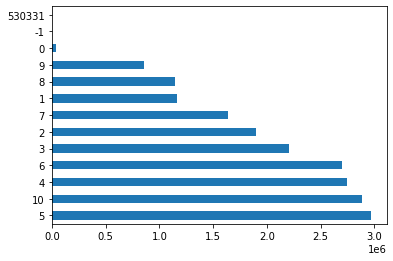

In [24]:
epc_df.FLOOR_AREA.value_counts().plot(kind='barh')

<AxesSubplot:>

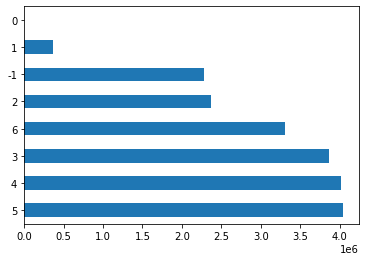

In [25]:
epc_df.LC4404_C_ROOMS.value_counts().plot(kind='barh')

<AxesSubplot:>

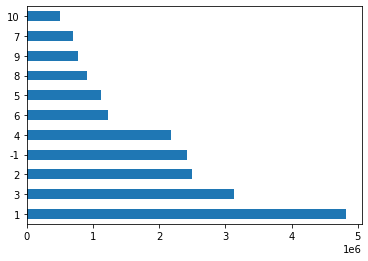

In [26]:
epc_df.ACCOM_AGE.value_counts().plot(kind='barh')

<AxesSubplot:>

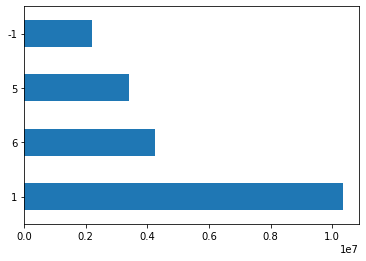

In [27]:
epc_df.LC4402_C_TENHUK11.value_counts().plot(kind='barh')

<AxesSubplot:>

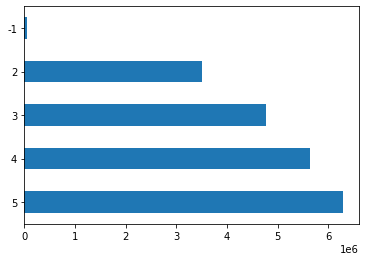

In [28]:
epc_df.LC4402_C_TYPACCOM.value_counts().plot(kind='barh')